In [ ]:
from google.colab import drive

# # Loading data to colab
drive.mount('/content/drive')

!mkdir Dataset
!cp -r /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘Dataset’: File exists
cp: missing destination file operand after '/content/drive/MyDrive/'
Try 'cp --help' for more information.


### Libraries

In [ ]:
!pip install pyspark

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StringIndexer
from pyspark.ml.stat import Correlation

from pyspark.ml.linalg import Vectors

from pyspark.sql.functions import *
from pyspark.ml.functions import array_to_vector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


import numpy as np
from numpy import allclose
from collections import Counter

from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier, RandomForestClassificationModel, MultilayerPerceptronClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc


### Spark session and dataset load


In [ ]:
spark = SparkSession.builder.appName("Classification").getOrCreate()

In [ ]:
df = spark.read.csv('/content/drive/Shareddrives/DDAM - Project/final_df.csv', header=True, inferSchema=True)

In [ ]:
# derivations casting
new_der_columns = [f"Der{i}" for i in range(1, 13)]
for col_name in new_der_columns:
    df = df.withColumn(col_name, split(col(col_name), ",").cast("array<int>"))

# other columns casting (Excluding 3)
for col_name in df.columns:
    if col_name not in ["Patient_ID", "Sex", "DiagnosticCode"] + new_der_columns:
        df = df.withColumn(col_name, col(col_name).cast("int"))

# Correlation matrix

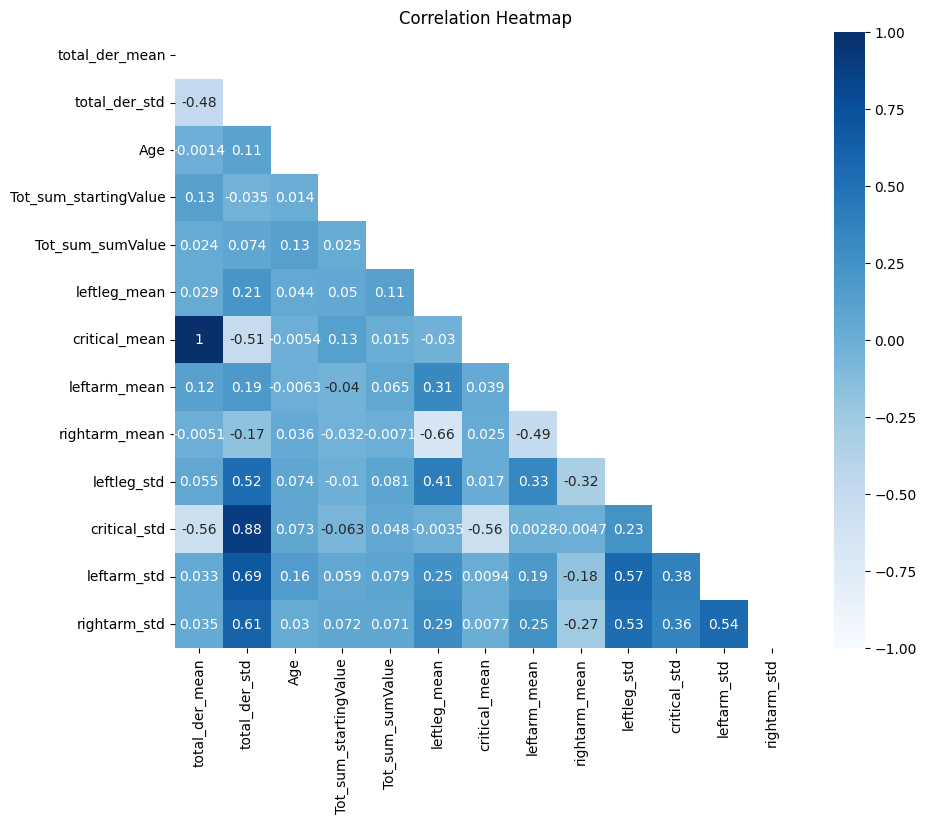

In [ ]:
input_columns = ["total_der_mean", "total_der_std", "Age", "Tot_sum_startingValue",
                 "Tot_sum_sumValue", "leftleg_mean", "critical_mean", "leftarm_mean",
                 "rightarm_mean", "leftleg_std", "critical_std", "leftarm_std",
                 "rightarm_std"]

vector_col = "corr_features"

# Creating a VectorAssembler
vecAssembler = VectorAssembler(
    inputCols=input_columns,
    outputCol=vector_col
)

# Transforming the DataFrame using VectorAssembler
df_vector = vecAssembler.transform(df).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

# Converting the correlation matrix to a Pandas DataFrame to better display the results
correlation_matrix = pd.DataFrame(matrix.toArray(), columns=input_columns, index=input_columns)

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
#We drop total_der_mean since it is high correlated with critical_mean and also Patient_ID since it's useless as predictive variable
df = df.drop('total_der_mean', 'Patient_ID')
df.describe

<bound method DataFrame.describe of DataFrame[Sex: string, StartingValue1: int, StartingValue2: int, StartingValue3: int, StartingValue4: int, StartingValue5: int, StartingValue6: int, StartingValue7: int, StartingValue8: int, StartingValue9: int, StartingValue10: int, StartingValue11: int, StartingValue12: int, SumValues1: int, SumValues2: int, SumValues3: int, SumValues4: int, SumValues5: int, SumValues6: int, SumValues7: int, SumValues8: int, SumValues9: int, SumValues10: int, SumValues11: int, SumValues12: int, Age: int, DiagnosticCode: int, Tot_sum_startingValue: int, Tot_sum_sumValue: int, Bpm_Mean1: int, Bpm_Mean2: int, Bpm_Mean3: int, Bpm_Mean4: int, Bpm_Mean5: int, Bpm_Mean6: int, Bpm_Mean7: int, Bpm_Mean8: int, Bpm_Mean9: int, Bpm_Mean10: int, Bpm_Mean11: int, Bpm_Mean12: int, leftleg_mean: int, critical_mean: int, leftarm_mean: int, rightarm_mean: int, leftleg_std: int, critical_std: int, leftarm_std: int, rightarm_std: int, total_der_std: int, Der1: array<int>, Der2: array<

# Data preparation

In [ ]:
#create sex indexed
stringIndexer = StringIndexer(inputCol="Sex", outputCol="SexIndexed")
si_model = stringIndexer.fit(df)
df = si_model.transform(df)
df = df.drop("Sex")

In [ ]:
#since we extract features
df = df.drop('Der1','Der2','Der3','Der4','Der5','Der6','Der7','Der8','Der9','Der10','Der11','Der12')

In [ ]:
# Creating and fitting a VectorAssembler

withoutDx = df.columns
withoutDx.remove('DiagnosticCode')

column = withoutDx

vecAssembler = VectorAssembler(
    inputCols= withoutDx,
    outputCol='vector_col',
    handleInvalid="skip"
)

df_vector = vecAssembler.transform(df).select('DiagnosticCode','vector_col')

In [ ]:
# we scale all the features
mmScaler = MinMaxScaler(outputCol="scaled")
mmScaler.setInputCol("vector_col")
model = mmScaler.fit(df_vector)
df_vector_scaled = model.transform(df_vector).select('DiagnosticCode','scaled')

In [ ]:
df_vector_scaled.show()

+--------------+--------------------+
|DiagnosticCode|              scaled|
+--------------+--------------------+
|             1|[0.40932642487046...|
|             1|[0.40932642487046...|
|             1|[0.41709844559585...|
|             0|[0.41968911917098...|
|             1|[0.39507772020725...|
|             1|[0.40025906735751...|
|             1|[0.38471502590673...|
|             1|[0.38082901554404...|
|             1|[0.41450777202072...|
|             0|[0.38341968911917...|
|             1|[0.40414507772020...|
|             0|[0.41062176165803...|
|             1|[0.42875647668393...|
|             1|[0.34974093264248...|
|             1|[0.41968911917098...|
|             1|[0.36528497409326...|
|             0|[0.43264248704663...|
|             0|[0.41321243523316...|
|             0|[0.43652849740932...|
|             1|[0.35233160621761...|
+--------------+--------------------+
only showing top 20 rows



In [ ]:
#Stratified training and test

#Filter in order to have in Has_HA all the patitent with Heart Attack and in No_HA all the patients without Heart Attack
Has_HA = df_vector_scaled.filter(df_vector_scaled["DiagnosticCode"]==1)
No_HA = df_vector_scaled.filter(df_vector_scaled["DiagnosticCode"]==0)

#Split datasets into training and testing
train0, test0 = Has_HA.randomSplit([0.8,0.2], seed=42)
train1, test1 = No_HA.randomSplit([0.8,0.2], seed=42)

#Union
train = train0.union(train1)
test = test0.union(test1)

In [ ]:
print("Train:",train.count())
print("Test:",test.count())

Train: 1760
Test: 406


In [ ]:
# To show how much is unbalanced the training
print(train.filter("DiagnosticCode = 0").count())
print(train.filter("DiagnosticCode = 1").count())

638
1122


In [ ]:
# Create a balanced training with random oversampling with replacement
No_HA = train.filter("DiagnosticCode = 0")
sampled_df = No_HA.sample(withReplacement=True, fraction= 0.75, seed=42)
train_oversampled = train.unionAll(sampled_df)

In [ ]:
print(train_oversampled.filter("DiagnosticCode = 0").count())
print(train_oversampled.filter("DiagnosticCode = 1").count())

1123
1122


# Random Forest model

### Model

In [ ]:
rfc = RandomForestClassifier(labelCol="DiagnosticCode", seed=42)

In [ ]:
rfc.setFeaturesCol('scaled')

RandomForestClassifier_8a35294b757e

#### Code below give us the best model via grid search for the imbalanced and balanced data

In [ ]:
# No need to execute since is computationally expensive and we save the model we get
# Define the hyperparameter grid for imbalanced dataset
'''paramGrid = ParamGridBuilder() \
    .addGrid(rfc.numTrees, [80]) \
    .addGrid(rfc.maxDepth, [6, 8, 12]) \
    .build()

# Create the cross-validator
cross_validator = CrossValidator(estimator=rfc,
                          estimatorParamMaps=paramGrid,
                          evaluator = BinaryClassificationEvaluator(labelCol="DiagnosticCode",metricName="areaUnderPR"),
                          numFolds=5, seed=42)

# Train the model with the best hyperparameters
cv_model = cross_validator.fit(train)

In [ ]:
'''best_model = cv_model.bestModel

# Get the best combination of hyperparameters
best_num_trees = best_model.getNumTrees
best_max_depth = best_model.getMaxDepth()

# Print the best configuration
print("Best configuration - NumTrees: {}, MaxDepth: {}".format(best_num_trees, best_max_depth))

Best configuration - NumTrees: 80, MaxDepth: 8


In [ ]:
#best_model.save('/content/drive/Shareddrives/DDAM - Project/RFC_UNBALANCED')

In [ ]:
# No need to execute since is computationally expensive and we save the model we get
# Define the hyperparameter grid for balance dataset
'''paramGrid = ParamGridBuilder() \
    .addGrid(rfc.numTrees, [80]) \
    .addGrid(rfc.maxDepth, [6, 8, 12]) \
    .build()

# Create the cross-validator
cross_validator = CrossValidator(estimator=rfc,
                          estimatorParamMaps=paramGrid,
                          evaluator = BinaryClassificationEvaluator(labelCol="DiagnosticCode",metricName="areaUnderPR"),
                          numFolds=5, seed=42)

# Train the model with the best hyperparameters
cv_model = cross_validator.fit(train_oversampled)

In [ ]:
'''best_model = cv_model.bestModel

# Get the best combination of hyperparameters
best_num_trees = best_model.getNumTrees
best_max_depth = best_model.getMaxDepth()

# Print the best configuration
print("Best configuration - NumTrees: {}, MaxDepth: {}".format(best_num_trees, best_max_depth))

In [ ]:
#best_model.save('/content/drive/Shareddrives/DDAM - Project/RFC_BALANCED')

### Evalutation


#### Model from imbalanced training data

In [ ]:
rfc_model= RandomForestClassificationModel.load('/content/drive/Shareddrives/DDAM - Project/RFC_UNBALANCED')

In [ ]:
best_num_trees = rfc_model.getNumTrees
best_max_depth = rfc_model.getMaxDepth()

# Print the best configuration
print("Best configuration - NumTrees: {}, MaxDepth: {}".format(best_num_trees, best_max_depth))

Best configuration - NumTrees: 80, MaxDepth: 6


In [ ]:
preds = rfc_model.transform(test)

In [ ]:
bce= BinaryClassificationEvaluator(rawPredictionCol= "rawPrediction",
                                   labelCol="DiagnosticCode",
                                   metricName= "areaUnderROC")


bce.evaluate(preds)

0.8719565046095659

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="DiagnosticCode", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(preds)
print("Accuracy:",accuracy)

Accuracy: 0.8004926108374384


In [ ]:
# Calculate precision and recall
true_positive = preds.filter("DiagnosticCode = 1 AND prediction = 1").count()
false_positive = preds.filter("DiagnosticCode = 0 AND prediction = 1").count()
false_negative = preds.filter("DiagnosticCode = 1 AND prediction = 0").count()

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print("Precision:",precision)
print("Recall:",recall)

Precision: 0.7664670658682635
Recall: 0.9884169884169884


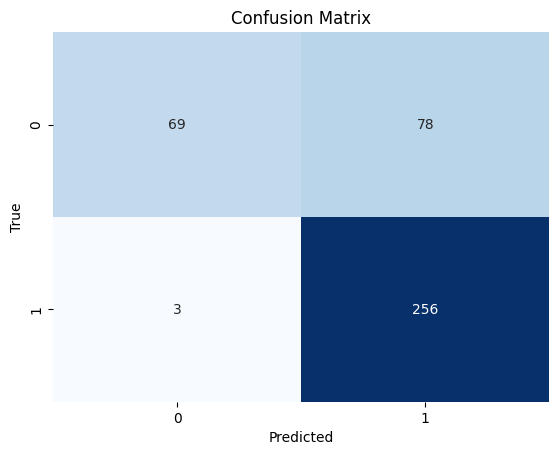

In [ ]:
# Confusion matrix

y_true = preds.select("DiagnosticCode").toPandas()
y_pred = preds.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Model from balanced training data

In [ ]:
#load the model obtained by gridsearch
rfc_model= RandomForestClassificationModel.load('/content/drive/Shareddrives/DDAM - Project/RFC_BALANCED')

In [ ]:
best_num_trees = rfc_model.getNumTrees
best_max_depth = rfc_model.getMaxDepth()

# Print the best configuration
print("Best configuration - NumTrees: {}, MaxDepth: {}".format(best_num_trees, best_max_depth))

Best configuration - NumTrees: 80, MaxDepth: 12


In [ ]:
preds = rfc_model.transform(test)

In [ ]:
bce= BinaryClassificationEvaluator(rawPredictionCol= "rawPrediction",
                                   labelCol="DiagnosticCode",
                                   metricName= "areaUnderROC")


bce.evaluate(preds)

0.9726052583195439

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="DiagnosticCode", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(preds)
print("Accuracy:",accuracy)

Accuracy: 0.9310344827586207


In [ ]:
# Calculate precision and recall
true_positive = preds.filter("DiagnosticCode = 1 AND prediction = 1").count()
false_positive = preds.filter("DiagnosticCode = 0 AND prediction = 1").count()
false_negative = preds.filter("DiagnosticCode = 1 AND prediction = 0").count()

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print("Precision:",precision)
print("Recall:",recall)

Precision: 0.9169675090252708
Recall: 0.9806949806949807


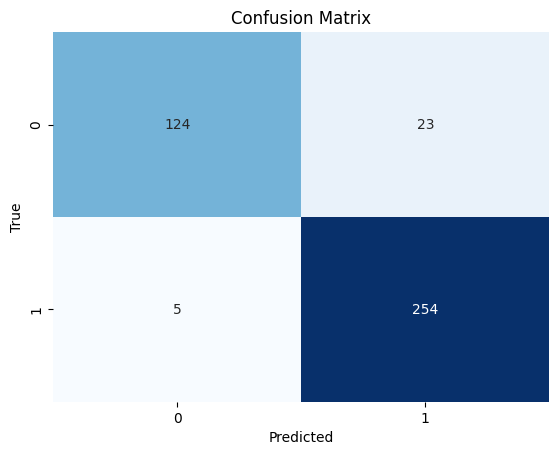

In [ ]:
# Confusion matrix

y_true = preds.select("DiagnosticCode").toPandas()
y_pred = preds.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#just to rename the features to plot
columns = []
new_name = ['Bpm_Mean_I','Bpm_Mean_II','Bpm_Mean_III','Bpm_Mean_aVr','Bpm_Mean_aVL','Bpm_Mean_aVF',
            'Bpm_Mean_V1','Bpm_Mean_V2','Bpm_Mean_V3','Bpm_Mean_V4','Bpm_Mean_V5','Bpm_Mean_V6']
i = 0
for e in column:
  if 'Bpm_Mean' in e:
    columns.append(new_name[i])
    i+=1
  else:
    columns.append(e)

In [ ]:
columns

['StartingValue1',
 'StartingValue2',
 'StartingValue3',
 'StartingValue4',
 'StartingValue5',
 'StartingValue6',
 'StartingValue7',
 'StartingValue8',
 'StartingValue9',
 'StartingValue10',
 'StartingValue11',
 'StartingValue12',
 'SumValues1',
 'SumValues2',
 'SumValues3',
 'SumValues4',
 'SumValues5',
 'SumValues6',
 'SumValues7',
 'SumValues8',
 'SumValues9',
 'SumValues10',
 'SumValues11',
 'SumValues12',
 'Age',
 'Tot_sum_startingValue',
 'Tot_sum_sumValue',
 'Bpm_Mean_I',
 'Bpm_Mean_II',
 'Bpm_Mean_III',
 'Bpm_Mean_aVr',
 'Bpm_Mean_aVL',
 'Bpm_Mean_aVF',
 'Bpm_Mean_V1',
 'Bpm_Mean_V2',
 'Bpm_Mean_V3',
 'Bpm_Mean_V4',
 'Bpm_Mean_V5',
 'Bpm_Mean_V6',
 'leftleg_mean',
 'critical_mean',
 'leftarm_mean',
 'rightarm_mean',
 'leftleg_std',
 'critical_std',
 'leftarm_std',
 'rightarm_std',
 'total_der_std',
 'SexIndexed']

In [ ]:
def get_features_importance(dataset= df, model= rfc_model):

    sparse= model.featureImportances
    vals= sparse.values
    idx= sparse.indices
    feature_names= [(columns)[i] for i in idx]
    importances_df= pd.DataFrame(zip(feature_names, vals), columns=["feature", "value"])
    return importances_df

<ipython-input-57-8493e0107906>:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, pad=0.1)


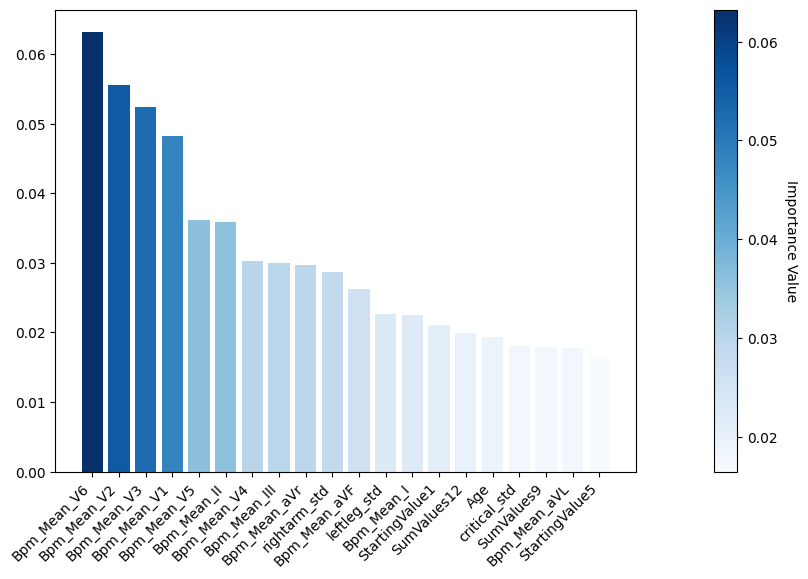

In [ ]:
# Feature importance plot

rfc_importance_df= get_features_importance().sort_values(by='value',ascending=False)

rfc_importance_df = rfc_importance_df.head(20)

norm = Normalize(vmin = rfc_importance_df['value'].min(), vmax = rfc_importance_df['value'].max())
colors = plt.cm.Blues(norm(rfc_importance_df['value']))

fig, ax = plt.subplots(figsize=(10, 6))
bars = plt.bar(rfc_importance_df['feature'], rfc_importance_df['value'], color=colors)
plt.xticks(rotation=45, ha='right')

sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, pad=0.1)
cbar.set_label('Importance Value', rotation=270, labelpad=15)

plt.show()

# Neural Network model

### Model

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='DiagnosticCode', predictionCol='prediction', metricName = 'accuracy')
layers = [len(vecAssembler.getInputCols()), 40,20, 2]


In [ ]:
#no need to execute the line below since we import the model in the last cell before 'Evaluation' section

'''trainer = MultilayerPerceptronClassifier(layers = layers, labelCol='DiagnosticCode', featuresCol='scaled')

param_grid = ParamGridBuilder().addGrid(trainer.layers, [[len(vecAssembler.getInputCols()), 20, 10, 5, 2],[len(vecAssembler.getInputCols()), 30, 15,10,7, 2],[len(vecAssembler.getInputCols()), 40, 20, 2]]).build()

crossval = CrossValidator(estimator= trainer,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)

In [ ]:
#cv_model = crossval.fit(train_oversampled)


In [ ]:
#best_model = cv_model.bestModel

In [ ]:
#best_model.save('/content/drive/Shareddrives/DDAM - Project/Neural_network')

In [ ]:
best_model = MultilayerPerceptronClassificationModel.load('/content/drive/Shareddrives/DDAM - Project/Neural_network')

# Evaluation

In [ ]:
prediction = best_model.transform(test)


In [ ]:
params = best_model.extractParamMap()

# Print the parameters
print("Best model parameters:")
for param, value in params.items():
    print("{}: {}".format(param.name, value))

Best model parameters:
blockSize: 128
featuresCol: scaled
labelCol: DiagnosticCode
maxIter: 100
predictionCol: prediction
probabilityCol: probability
rawPredictionCol: rawPrediction
seed: -221787752041816854
solver: l-bfgs
stepSize: 0.03
tol: 1e-06
layers: [49, 20, 10, 5, 2]


In [ ]:
evaluate2 = evaluator.evaluate(prediction) #ACCURACY
evaluate2

0.7142857142857143

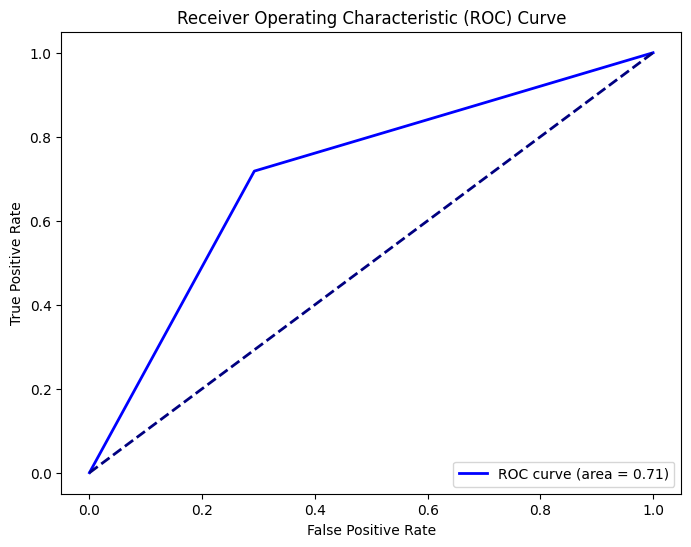

In [ ]:
# ROC CURVE

y_true = prediction.select("DiagnosticCode").toPandas()
y_scores = prediction.select("prediction").toPandas()

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

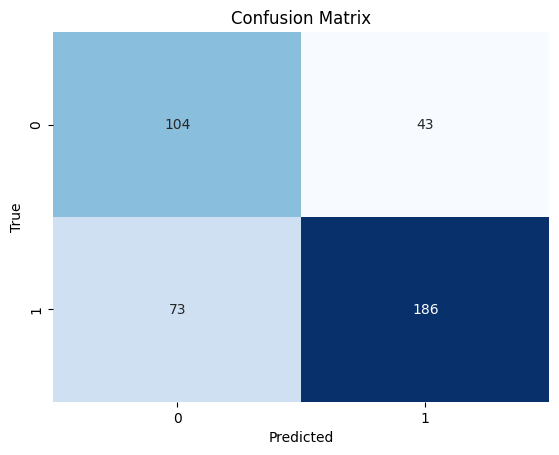

In [ ]:
# Confusion matrix

y_true = prediction.select("DiagnosticCode").toPandas()
y_pred = prediction.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()